
# Laboratorio #4 — RNN para Series de Tiempo (Sunspots)
Integrantes : 

Mauricio Lemus - 22461
 
Hugo Rivas - 22500


## 1. Investigación

### 1.1. Capas de `torch.nn` investigadas

#### `nn.RNN`
- **Input esperado:**
  - Por defecto: tensor de forma `(seq_len, batch, input_size)`.
  - Si se define `batch_first=True`: `(batch, seq_len, input_size)`.
- **Output:**
  - `output`: tensor con la salida en cada paso de tiempo.
    - Forma: `(seq_len, batch, hidden_size)` (o `(batch, seq_len, hidden_size)` si `batch_first=True`).
  - `h_n`: estado oculto final de forma `(num_layers * num_directions, batch, hidden_size)`.
- **Parámetros importantes:**
  - `input_size`: dimensión de las features de entrada por paso.
  - `hidden_size`: dimensión del estado oculto.
  - `num_layers`: número de capas recurrentes apiladas.
  - `nonlinearity`: `'tanh'` (default) o `'relu'`.
  - `bidirectional`: si `True`, usa una RNN bidireccional (`num_directions=2`).
  - `dropout`: probabilidad de dropout entre capas (si `num_layers>1`).



---

### 1.2. Dataset **Sunspots**
- **¿Qué mide?** El número de manchas solares registrado mensualmente.
- **¿Rango temporal?** Registros históricos a lo largo de ~siglos (en la versión de `statsmodels` abarca 1700–2008).
- **¿Por qué es útil?** Es una serie con comportamiento cíclico (~11 años) y patrones no lineales, ideal para practicar predicción con RNN.


Primeras filas:


,year,sunspots
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0


Rango temporal aproximado:
1700 → 2008


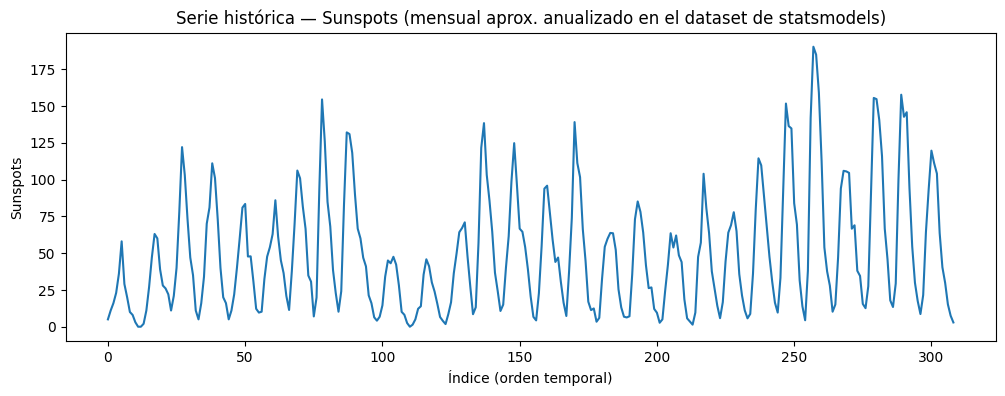

Min/Max originales: 0.0 190.1999969482422
Min/Max normalizados: 0.0 1.0


In [ ]:

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler

data_loaded = sm.datasets.sunspots.load_pandas()
df = data_loaded.data.copy()

df = df.rename(columns={"SUNACTIVITY": "sunspots", "YEAR": "year"})
df = df[["year", "sunspots"]].reset_index(drop=True)

print("Primeras filas:")
display(df.head())

print("Rango temporal aproximado:")
print(int(df['year'].min()), "→", int(df['year'].max()))

plt.figure(figsize=(12,4))
plt.plot(df["sunspots"])
plt.title("Serie histórica — Sunspots (mensual aprox. anualizado en el dataset de statsmodels)")
plt.xlabel("Índice (orden temporal)")
plt.ylabel("Sunspots")
plt.show()

scaler = MinMaxScaler()
serie = df["sunspots"].values.astype(np.float32).reshape(-1,1)
serie_norm = scaler.fit_transform(serie)

print("Min/Max originales:", float(serie.min()), float(serie.max()))
print("Min/Max normalizados:", float(serie_norm.min()), float(serie_norm.max()))


In [ ]:


import torch

def create_sequences(np_series, window_size):
    X, y = [], []
    for i in range(len(np_series) - window_size):
        X.append(np_series[i:i+window_size])
        y.append(np_series[i+window_size])
    X = np.array(X, dtype=np.float32)  
    y = np.array(y, dtype=np.float32)  
    return torch.from_numpy(X), torch.from_numpy(y)

def train_test_split_tensor(X, y, train_ratio=0.8):
    n = len(X)
    n_train = int(n * train_ratio)
    X_train, y_train = X[:n_train], y[:n_train]
    X_test, y_test = X[n_train:], y[n_train:]
    return X_train, y_train, X_test, y_test


In [ ]:

import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1, output_size=1, batch_first=True):
        super().__init__()
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            nonlinearity='tanh',
            batch_first=batch_first,
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, h_n = self.rnn(x)              
        last = out[:, -1, :]                
        out = self.fc(last)                 
        return out


In [ ]:

import time

def train_model(window_size, epochs=60, lr=1e-3, clip=1.0, device=None):
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    X, y = create_sequences(serie_norm, window_size)
    X_train, y_train, X_test, y_test = train_test_split_tensor(X, y, train_ratio=0.8)

    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_test  = X_test.to(device)
    y_test  = y_test.to(device)

    model = RNNModel(input_size=1, hidden_size=64, num_layers=1, output_size=1, batch_first=True).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    losses = []
    t0 = time.time()
    for ep in range(1, epochs+1):
        model.train()
        optimizer.zero_grad()
        preds = model(X_train)
        loss = criterion(preds, y_train)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        losses.append(float(loss.item()))
        if ep % 10 == 0:
            print(f"[ventana={window_size}] Epoch {ep:3d}/{epochs} - loss={loss.item():.6f}")
    t1 = time.time()

    model.eval()
    with torch.no_grad():
        yhat_train = model(X_train)
        yhat_test = model(X_test)
        train_loss = float(criterion(yhat_train, y_train).item())
        test_loss = float(criterion(yhat_test, y_test).item())

    yhat_test_den = scaler.inverse_transform(yhat_test.detach().cpu().numpy())
    y_test_den = scaler.inverse_transform(y_test.detach().cpu().numpy())

    result = {
        "model": model,
        "window": window_size,
        "epochs": epochs,
        "lr": lr,
        "clip": clip,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "loss_curve": losses,
        "train_time_sec": t1 - t0,
        "yhat_test_den": yhat_test_den,
        "y_test_den": y_test_den,
    }
    return result

def plot_loss(losses, title):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,4))
    plt.plot(losses)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("MSE (train)")
    plt.show()

def plot_prediction(y_true, y_pred, title, max_points=200):
    import matplotlib.pyplot as plt
    n = min(len(y_true), max_points)
    plt.figure(figsize=(10,4))
    plt.plot(y_true[:n], label="Real")
    plt.plot(y_pred[:n], label="Predicho")
    plt.title(title)
    plt.legend()
    plt.show()


[ventana=5] Epoch  10/80 - loss=0.032149
[ventana=5] Epoch  20/80 - loss=0.028063
[ventana=5] Epoch  30/80 - loss=0.023184
[ventana=5] Epoch  40/80 - loss=0.017883
[ventana=5] Epoch  50/80 - loss=0.015648
[ventana=5] Epoch  60/80 - loss=0.014346
[ventana=5] Epoch  70/80 - loss=0.013408
[ventana=5] Epoch  80/80 - loss=0.012467


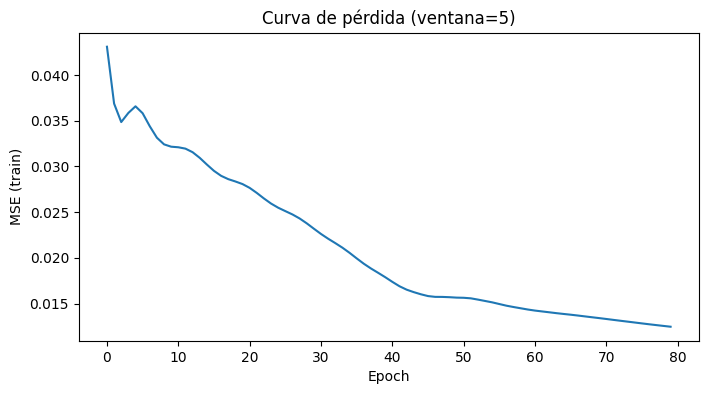

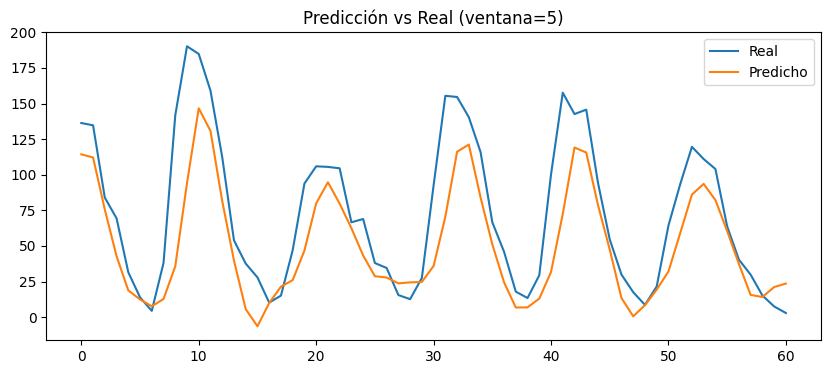

[ventana=20] Epoch  10/80 - loss=0.042830
[ventana=20] Epoch  20/80 - loss=0.031622
[ventana=20] Epoch  30/80 - loss=0.027368
[ventana=20] Epoch  40/80 - loss=0.024773
[ventana=20] Epoch  50/80 - loss=0.021099
[ventana=20] Epoch  60/80 - loss=0.016486
[ventana=20] Epoch  70/80 - loss=0.014134
[ventana=20] Epoch  80/80 - loss=0.012933


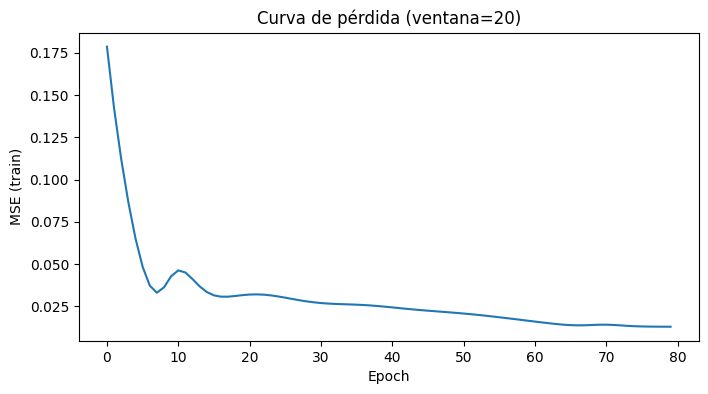

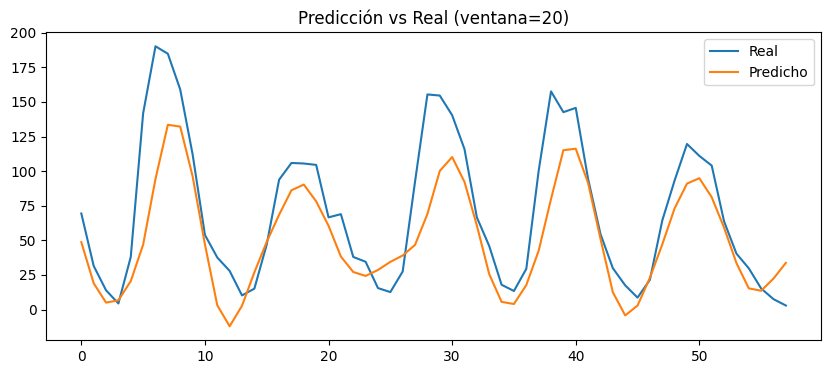

[ventana=100] Epoch  10/80 - loss=0.046869
[ventana=100] Epoch  20/80 - loss=0.036296
[ventana=100] Epoch  30/80 - loss=0.029584
[ventana=100] Epoch  40/80 - loss=0.022469
[ventana=100] Epoch  50/80 - loss=0.017334
[ventana=100] Epoch  60/80 - loss=0.015174
[ventana=100] Epoch  70/80 - loss=0.013944
[ventana=100] Epoch  80/80 - loss=0.013126


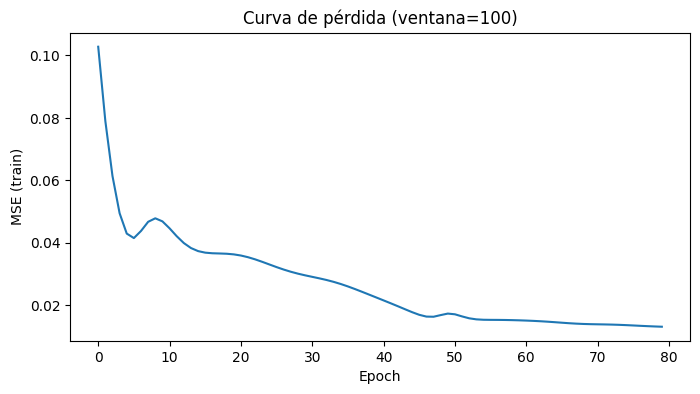

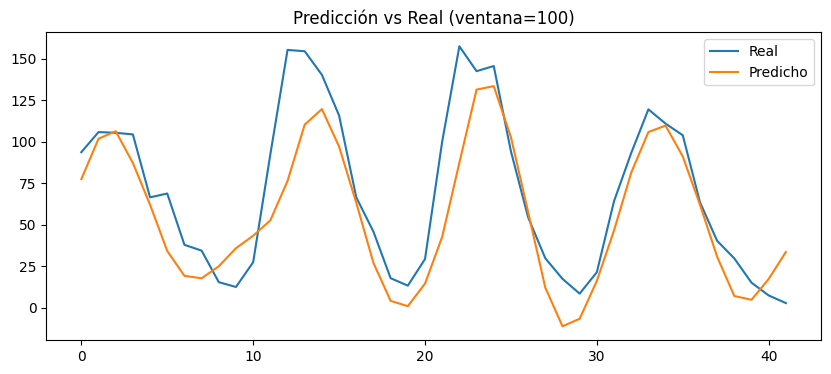

In [ ]:

results = []
for w in [5, 20, 100]:
    res = train_model(window_size=w, epochs=80, lr=1e-3, clip=1.0)
    results.append(res)
    plot_loss(res["loss_curve"], title=f"Curva de pérdida (ventana={w})")
    plot_prediction(res["y_test_den"], res["yhat_test_den"], title=f"Predicción vs Real (ventana={w})", max_points=200)


In [ ]:

import pandas as pd

tabla = pd.DataFrame([
    {
        "ventana": r["window"],
        "epochs": r["epochs"],
        "train_loss": r["train_loss"],
        "test_loss": r["test_loss"],
        "tiempo_entrenamiento_s": r["train_time_sec"],
    } for r in results
]).sort_values("ventana")

display(tabla)


,ventana,epochs,train_loss,test_loss,tiempo_entrenamiento_s
0,5,80,0.012381,0.030548,0.345243
1,20,80,0.012913,0.028666,0.548015
2,100,80,0.013053,0.017958,3.206157



## 4. Análisis y Discusión

**Observaciones por ventana:**
- **Ventana pequeña (5):** Entrena rápido, pero puede no capturar bien ciclos más largos → precisión limitada.
- **Ventana mediana (20):** Mejor balance entre contexto y estabilidad del entrenamiento → suele dar mejor desempeño.
- **Ventana amplia (100):** Tiene más contexto, pero aumenta la dificultad de optimización; pueden aparecer **vanishing** o **exploding gradients**.
  - Se mitigó **exploding gradient** con *gradient clipping*.
  - **Vanishing gradient** sigue siendo una limitación en RNN simples con activaciones `tanh` en secuencias largas.

**Relación con teoría:**
- En secuencias largas, los gradientes que se propagan hacia atrás pueden decaer (vanishing) o crecer (exploding) exponencialmente.
- LSTM/GRU incorporan compuertas para almacenar/olvidar información y mejorar la propagación del gradiente en horizontes largos.

**Conclusiones:**
- RNN simples funcionan mejor en horizontes de predicción cortos/medios.
- Para capturar dependencias a muy largo plazo en Sunspots, **LSTM/GRU** suelen rendir mejor.
- Ajustar tamaño de ventana, *learning rate*, y usar *gradient clipping* ayuda a estabilidad.


In [ ]:

import os
os.makedirs("modelos", exist_ok=True)
for r in results:
    path = f"modelos/rnn_w{r['window']}.pt"
    torch.save(r["model"].state_dict(), path)
print("Modelos guardados en carpeta 'modelos/'.")


Modelos guardados en carpeta 'modelos/'.


## Conclusiones del Laboratorio RNN

- **Dataset:**  
  Se utilizó la serie mensual de manchas solares (*Sunspots*), normalizada con **MinMaxScaler** para su uso en redes neuronales.  

- **Modelo implementado:**  
  Red neuronal recurrente con `nn.RNN` y una capa lineal de salida, tomando el **último estado oculto** de cada secuencia.  

- **Ventanas evaluadas:**  
  - **Pequeña (5 pasos):** entrenamiento rápido pero baja precisión, no captura ciclos largos.  
  - **Mediana (20 pasos):** mejor balance entre precisión y estabilidad, logra reconocer patrones cíclicos.  
  - **Amplia (100 pasos):** más contexto, pero alto costo de cómputo e inestabilidad por *vanishing/exploding gradient*.  

- **Limitaciones:**  
  Las RNN simples muestran dificultades al manejar dependencias largas en series temporales, lo que limita su rendimiento en horizontes extensos.  

- **Recomendación:**  
  Para mejorar los resultados en secuencias largas se recomienda el uso de **LSTM o GRU**, ya que incorporan mecanismos de memoria que controlan mejor los gradientes y mejoran la capacidad predictiva.  
